# Implementacja auto-enkodera używającego jednej warstwy MaxPooling2D

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import Model, load_model
from keras.datasets import mnist
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
from keras import optimizers
from keras import backend as K
import os
import csv
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from google.colab import drive

# Tworzenie potrzebnych folderów na dysku Google

drive.mount('/content/drive')

!mkdir -p "/content/drive/My Drive/SSN Projekt"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Double_MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/MaxPooling2D"
!mkdir -p "/content/drive/My Drive/SSN Projekt/Dense"

Mounted at /content/drive


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizacja danych
x_train = x_train.reshape(-1, 28, 28) / 255.0
x_test = x_test.reshape(-1, 28, 28) / 255.0

folder_base = "/content/drive/My Drive/SSN Projekt/"

4422102/4422102 [==============================] - 0s 0us/step


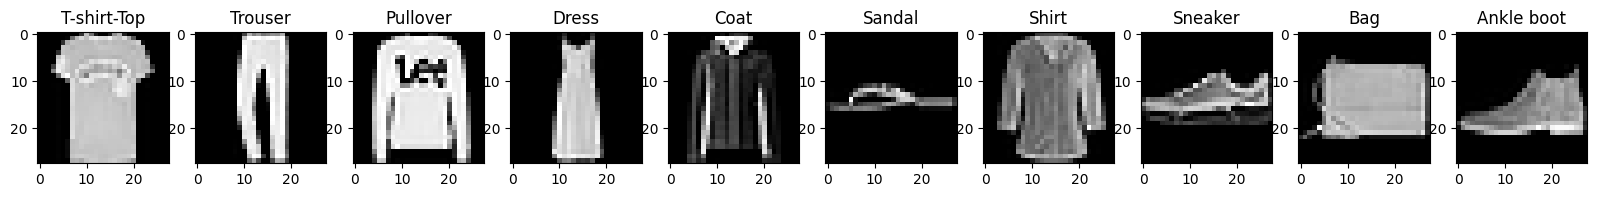

In [ ]:
labeldict = {
    0: 'T-shirt-Top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

items_train = []
items_test = []

for i in range(10):
  items_train.append([])
  items_test.append([])
  for j in range(len(x_train)):
    if y_train[j]==i:
      items_train[i].append(x_train[j])
  for j in range(len(x_test)):
    if y_test[j]==i:
      items_test[i].append(x_test[j])

fig, ax = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    ax[i].imshow(items_test[i][0], cmap='gray')
    ax[i].set_title(labeldict[i])

In [ ]:
# Klasa która pozwala tworzyć autoenkoder o wybranym poziomie kompresji
class MaxPooling2D_autoencoder:
    def __init__(self, x_train, x_test, y_train, y_test, name, cut_shape):
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.name = name
        self.cut_shape = cut_shape
        self.input = Input(shape=(28, 28, 1))
        self.model, self.encoder, self.decoder = self.build_model(cut_shape)

    def build_model(self, cut_shape):
        #Budowanie modelu
        inputs = self.input
        inputs = Input(shape=(28, 28, 1))

        x = Conv2D(300, (3, 3), activation='relu', padding='same')(inputs)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Flatten()(x)
        x = Dense(14*14, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded = Dense(cut_shape, activation='relu')(x)

        encoder = Model(inputs=inputs, outputs=encoded)
        encoded_inputs = Input(shape=(cut_shape,))

        x = Dense(cut_shape, activation='relu')(encoded_inputs)
        x = Dense(14*14, activation='relu')(x)
        x = Reshape((14, 14, 1))(x)
        x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
        x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(150, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(300, (3, 3), activation='relu', padding='same')(x)
        decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

        decoder = Model(inputs=encoded_inputs, outputs=decoded)

        def psnr(y_true, y_pred):
          mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
          psnr = 10 * tf.experimental.numpy.log10(1.0 / tf.math.sqrt(mse))
          return psnr

        x = encoder(inputs)
        x = decoder(x)
        model = Model(inputs=inputs, outputs=x)

        model.compile(optimizer=optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy', 'mse', psnr, 'mae'])

        print(model.summary())

        clr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_delta=0.01,
        cooldown=0,
        min_lr=1e-7,
        verbose=1)

        model.fit(
            x_train,
            x_train,
            batch_size=256,
            epochs=30,
            shuffle=True,
            validation_data=(x_test, x_test),
            callbacks=[clr])

        # Zapisywanie modelu na dysku Google

        folder = os.path.join(folder_base, "MaxPooling2D", str(cut_shape))

        print("Saving autoencoder")
        model_path = os.path.join(folder, "model.h5")
        model.save(model_path)

        print("Saving encoder")
        encoder_path = os.path.join(folder, "encoder.h5")
        encoder.save(encoder_path)

        print("Saving decoder")
        decoder_path = os.path.join(folder, "decoder.h5")
        decoder.save(decoder_path)

        # Zapisywanie historii na dysku Google

        history_path = os.path.join(folder, "history.csv")
        with open(history_path, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(["Epoch", "Loss", "Accuracy", "MSE", "VAL_MSE", "PSNR", "VAL_PSNR", "MAE", "VAL_MAE"])
            for i, loss in enumerate(model.history.history['loss']):
                epoch = i + 1
                acc = model.history.history['accuracy'][i]
                mse = model.history.history['mse'][i]
                val_mse = model.history.history['val_mse'][i]
                psnr = model.history.history['psnr'][i]
                val_psnr = model.history.history['val_psnr'][i]
                mae = model.history.history['mae'][i]
                val_mae = model.history.history['val_mae'][i]
                writer.writerow([epoch, loss, acc, mse, val_mse, psnr, val_psnr, mae, val_mae])

        return model, encoder, decoder

    def plot_image_reconstructions(self, all_index, items_per_category):
        # Wyświetlanie obrazów i macierzy liczbowych
        fig, axs = plt.subplots(2, 10 * items_per_category, figsize=(30 * items_per_category/2, 6))
        all_encoded = []
        all_labels = []
        mse_values = []
        psnr_values = []
        # Wyświetlanie obrazu przed enkoderem
        for i in range(10):
            for j in range(items_per_category):
              # Przekształcanie obrazu przez modele enkodera i dekodera
              input_image = items_test[i][all_index[i][0][j]]
              encoded_image = self.encoder.predict(np.expand_dims(input_image, axis=0))
              decoded_image = self.decoder.predict(encoded_image)

              # Pobieranie rozmiarów skompresowanych obrazów
              input_shape = input_image.shape[:2]
              encoded_shape = encoded_image.shape

              fig.suptitle(f'MaxPooling2D autoencoder - {self.cut_shape}', fontsize=16)

              # Wyświetlanie obrazu po dekoderze
              axs[0, i * items_per_category + j].imshow(input_image, cmap='gray')
              axs[0, i * items_per_category + j].set_title(labeldict[i] + str(j))
              axs[0, i * items_per_category + j].axis('off')

              # Wyświetlanie obrazu po dekoderze
              axs[1, i * items_per_category + j].imshow(decoded_image.squeeze(), cmap='gray')
              axs[1, i * items_per_category + j].axis('off')

              all_encoded.append([encoded_image, i, j])
              mse = mean_squared_error(input_image, decoded_image.squeeze())
              psnr = 10 * math.log10(1. / math.sqrt(mse))
              mse_values.append(mse)
              psnr_values.append(psnr)

        plt.tight_layout()
        plt.show()

        folder = os.path.join(folder_base, "MaxPooling2D", str(self.cut_shape), "Encoded")

        print("Encoded output")
        for i in range(len(all_encoded)) :
          print(f"Image {i+1} before decoder:")
          print(f"MSE: {mse_values[i]}")
          print(f"PSNR: {psnr_values[i]}")


          # Zapisywanie wartości liczbowych na wyjściu enkodera na dysku Google
          encoded_path = os.path.join(folder, labeldict[all_encoded[i][1]] + str(all_encoded[i][2]) + ".txt")
          os.makedirs(os.path.dirname(encoded_path), exist_ok=True)
          with open(encoded_path, mode='w') as file:
              file.write(str(all_encoded[i][0]))

    def apply_autoencoder(self, dataset):
        encoded_dataset = self.encoder.predict(dataset)
        decoded_dataset = self.decoder.predict(encoded_dataset)
        return decoded_dataset



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 49)                2010775   
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         823825    
                                                                 
Total params: 2,834,600
Trainable params: 2,833,268
Non-trainable params: 1,332
_________________________________________________________________
None
Epoch 1/30
235/235 [==============================] - 76s 257ms/step - loss: 0.3343 - accuracy: 0.4996 - mse: 0.0302 - psnr: 10.8657 - mae: 0.1002 - val_loss: 2.3973 - val_accuracy: 0.4999 - val_mse: 0.2063 - val_psnr: 7.6896 - val_mae: 0.2870 - lr: 0.0010
Epoch 2/30
235/235 [===========================

Saving encoder
Saving decoder
1/1 [==============================] - 0s 17ms/step


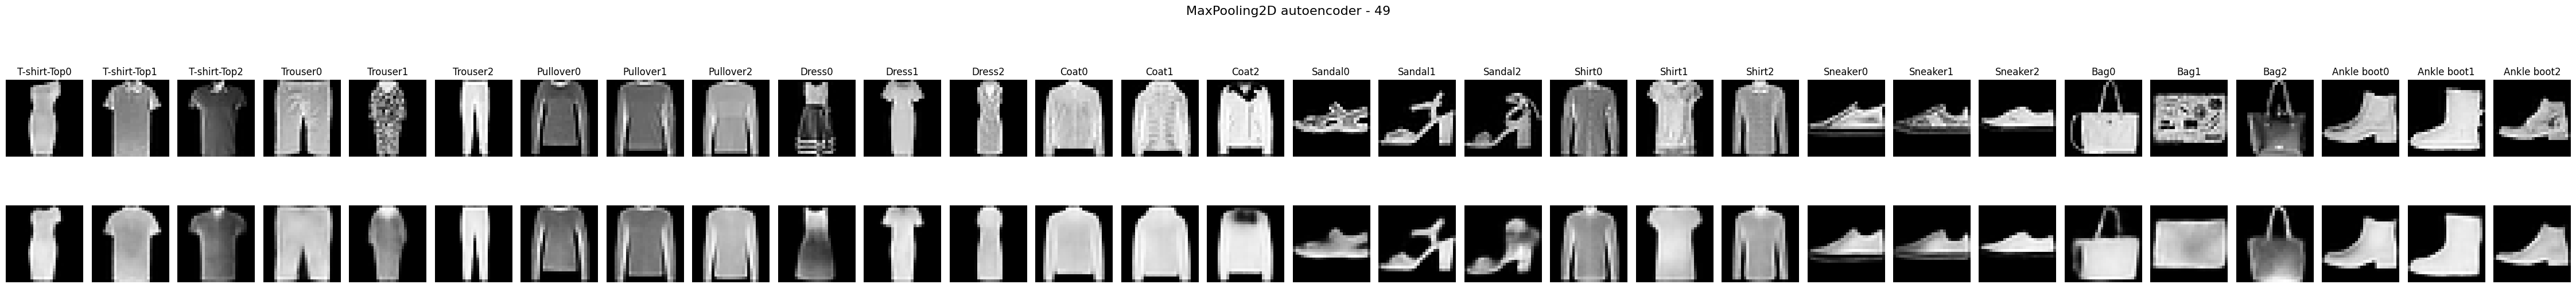

Encoded output
Image 1 before decoder:
MSE: 0.0027496652557916367
PSNR: 12.803600869778347
Image 2 before decoder:
MSE: 0.0032603628594944155
PSNR: 12.433670313914146
Image 3 before decoder:
MSE: 0.0028312408883230957
PSNR: 12.740115891572847
Image 4 before decoder:
MSE: 0.0075564569797291065
PSNR: 10.608408929125899
Image 5 before decoder:
MSE: 0.009491304987807241
PSNR: 10.113370355123891
Image 6 before decoder:
MSE: 0.0010866503047360255
PSNR: 14.819550969346139
Image 7 before decoder:
MSE: 0.0022715788432073514
PSNR: 13.21836092428056
Image 8 before decoder:
MSE: 0.002631720277663244
PSNR: 12.89880136617789
Image 9 before decoder:
MSE: 0.001822799622968538
PSNR: 13.696305349599525
Image 10 before decoder:
MSE: 0.013180002425765266
PSNR: 9.400422549052847
Image 11 before decoder:
MSE: 0.0029230445697774996
PSNR: 12.670822812947925
Image 12 before decoder:
MSE: 0.0033598808268801702
PSNR: 12.368380632613585
Image 13 before decoder:
MSE: 0.002042338510647612
PSNR: 13.449361367263728
I

Saving encoder
Saving decoder
1/1 [==============================] - 0s 19ms/step


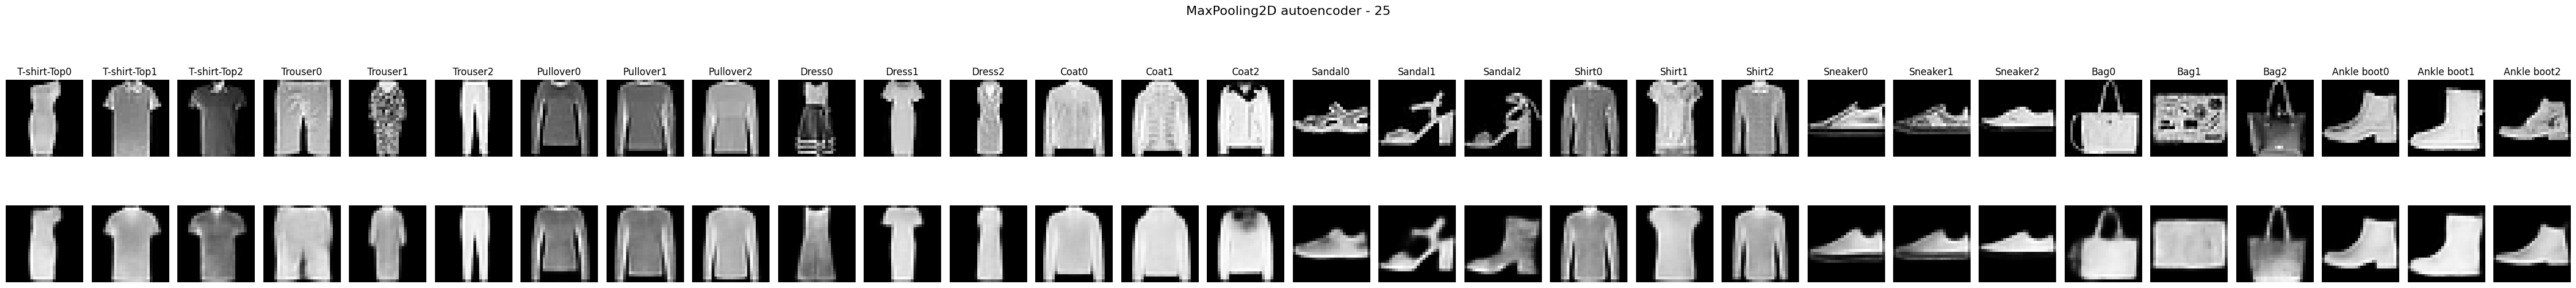

Encoded output
Image 1 before decoder:
MSE: 0.005686762999376143
PSNR: 11.225674354789739
Image 2 before decoder:
MSE: 0.004722197728495971
PSNR: 11.629279160199143
Image 3 before decoder:
MSE: 0.004657178134534299
PSNR: 11.659385751107525
Image 4 before decoder:
MSE: 0.010770090785484817
PSNR: 9.838903179206973
Image 5 before decoder:
MSE: 0.0121410965660053
PSNR: 9.57871043324854
Image 6 before decoder:
MSE: 0.0018334835376449161
PSNR: 13.683614925495537
Image 7 before decoder:
MSE: 0.003170646915900572
PSNR: 12.49426059215696
Image 8 before decoder:
MSE: 0.002988957549586317
PSNR: 12.62240126473557
Image 9 before decoder:
MSE: 0.0027417811279852613
PSNR: 12.809836085993261
Image 10 before decoder:
MSE: 0.020561697728746043
PSNR: 8.434705147852139
Image 11 before decoder:
MSE: 0.0032543310876810816
PSNR: 12.43769132546803
Image 12 before decoder:
MSE: 0.004352139101798511
PSNR: 11.80648616147346
Image 13 before decoder:
MSE: 0.003406834716149228
PSNR: 12.338244679395089
Image 14 befo

Saving encoder
Saving decoder
1/1 [==============================] - 0s 41ms/step


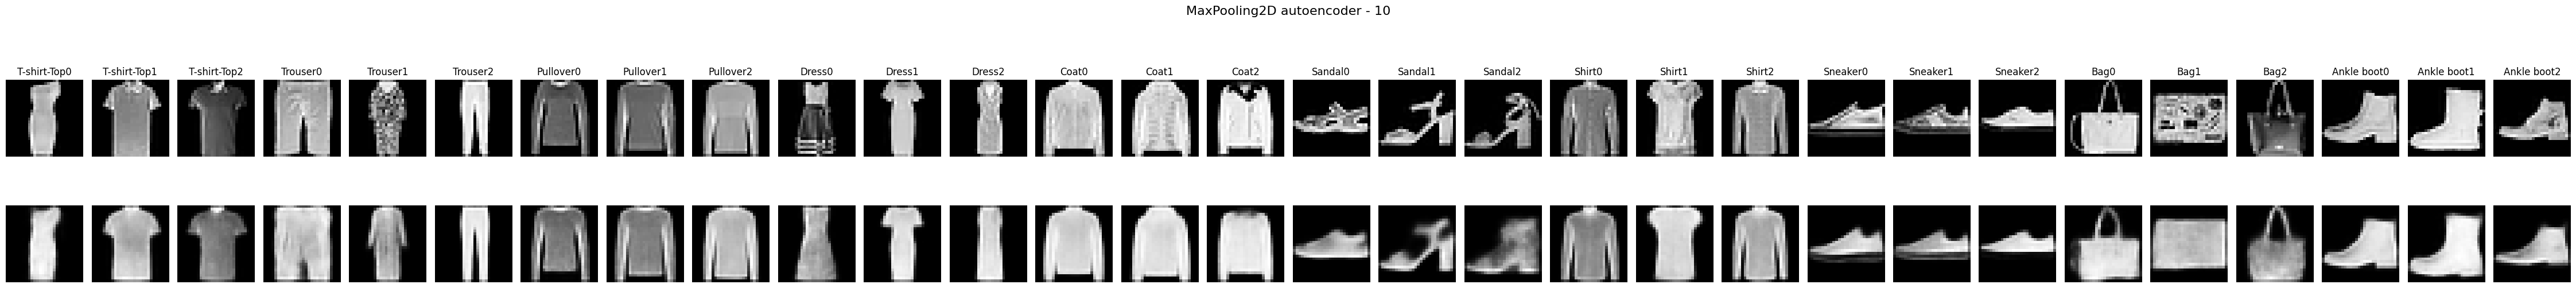

Encoded output
Image 1 before decoder:
MSE: 0.005039791490556978
PSNR: 11.487937155444738
Image 2 before decoder:
MSE: 0.007224735489697187
PSNR: 10.70589024283478
Image 3 before decoder:
MSE: 0.006030259760279897
PSNR: 11.098319898647189
Image 4 before decoder:
MSE: 0.017136674880217497
PSNR: 8.830367213483445
Image 5 before decoder:
MSE: 0.014479181477936717
PSNR: 9.19627994264982
Image 6 before decoder:
MSE: 0.0034715381578506203
PSNR: 12.297390283892401
Image 7 before decoder:
MSE: 0.0035474147444980383
PSNR: 12.250440166017665
Image 8 before decoder:
MSE: 0.0044283714020521584
PSNR: 11.768779812614154
Image 9 before decoder:
MSE: 0.0037542943636181057
PSNR: 12.12735839287933
Image 10 before decoder:
MSE: 0.023539540986964667
PSNR: 8.141010050022807
Image 11 before decoder:
MSE: 0.0038097487996573798
PSNR: 12.09551829553165
Image 12 before decoder:
MSE: 0.005823825657855517
PSNR: 11.1739581727373
Image 13 before decoder:
MSE: 0.005049467716498652
PSNR: 11.483772000467239
Image 14 b

Saving encoder
Saving decoder
1/1 [==============================] - 0s 26ms/step


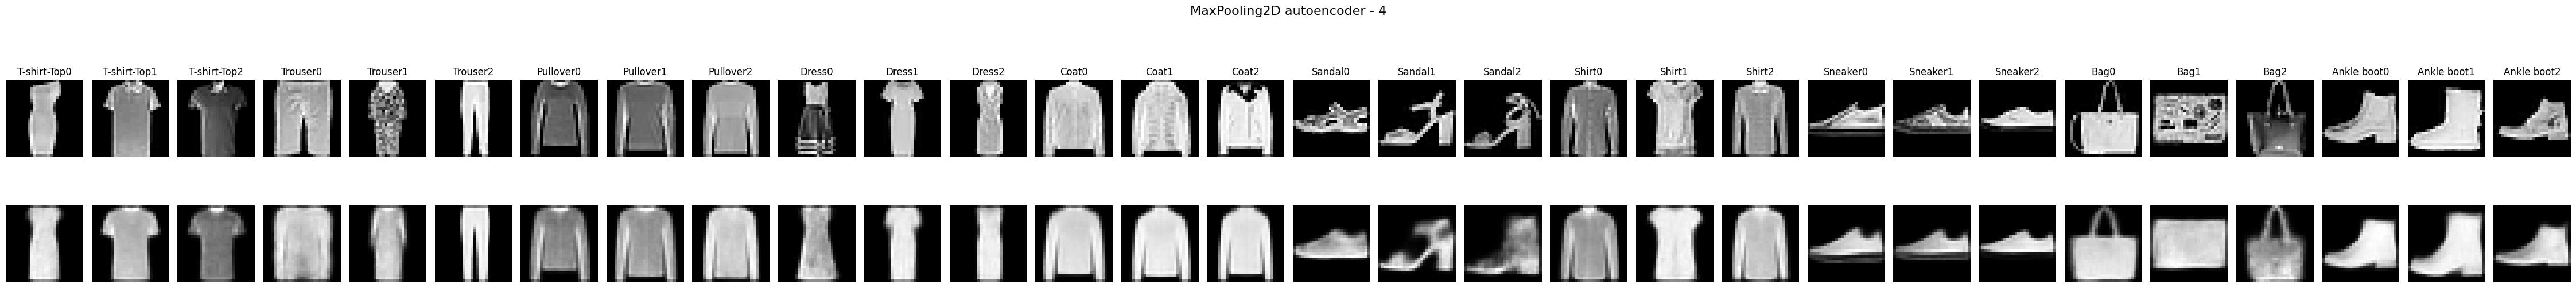

Encoded output
Image 1 before decoder:
MSE: 0.016377246766682795
PSNR: 8.9287955356311
Image 2 before decoder:
MSE: 0.0155794262217621
PSNR: 9.037242705496736
Image 3 before decoder:
MSE: 0.007799321963135673
PSNR: 10.539715756078468
Image 4 before decoder:
MSE: 0.022305820690591446
PSNR: 8.257908966384791
Image 5 before decoder:
MSE: 0.0170371141183294
PSNR: 8.843019837936922
Image 6 before decoder:
MSE: 0.004809592545962805
PSNR: 11.589458570870256
Image 7 before decoder:
MSE: 0.008535142928488193
PSNR: 10.343946009223101
Image 8 before decoder:
MSE: 0.007703388418796447
PSNR: 10.566591018361704
Image 9 before decoder:
MSE: 0.006568507251311723
PSNR: 10.912666581559984
Image 10 before decoder:
MSE: 0.026809494154437778
PSNR: 7.858556901366632
Image 11 before decoder:
MSE: 0.009032156552544534
PSNR: 10.221042717396738
Image 12 before decoder:
MSE: 0.011148001392376658
PSNR: 9.764014928578444
Image 13 before decoder:
MSE: 0.013143779433220365
PSNR: 9.406398687205744
Image 14 before dec

In [ ]:
# Tworzenie obiektów dla różnych wartości compression_level
maxpooling_cut = [156, 118, 78, 56]
maxpooling_cut_2 = [49, 25, 10, 4]
autoencoders = []

# Wybieranie losowych indeksów obrazów testowych - po 2 dla każdej klasy
num_samples = 3
all_indexes = []
for i in range(10):
  all_indexes.append([])
  all_indexes[i].append(random.sample(range(len(items_test[i])), num_samples))

for cut in maxpooling_cut:
    autoencoder = MaxPooling2D_autoencoder(x_train, x_test, y_train, y_test, f"MaxPooling2D_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)

for cut in maxpooling_cut_2:
    autoencoder = MaxPooling2D_autoencoder(x_train, x_test, y_train, y_test, f"MaxPooling2D_autoencoder_{cut}", cut)
    autoencoder.plot_image_reconstructions(all_indexes, num_samples)
    autoencoders.append(autoencoder)